<a href="https://colab.research.google.com/github/JulianEspinosaUrresti/ProyectoI-MIAA-2025/blob/main/Taller_2_AAIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Carga de Paquetes***

In [87]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta

### **2. Carga de Datos**

In [88]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(222, 4)


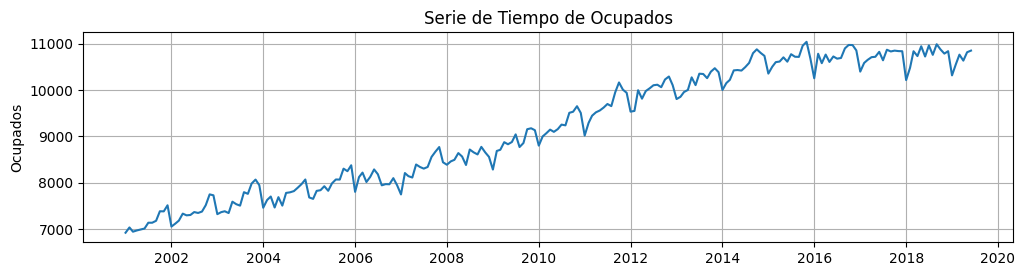

In [89]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Serie de Tiempo de Ocupados")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()

plt.show()

### **3. Autocorrelación**

Para determinar si existe autocorrelación usamos la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Las hipótesis son las siguientes:

H0:ρ=0  (Es decir no hay autocorrelación)

H1:ρ≠0  (Es decir hay autocorrelación)

Rechazo  H0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [90]:
signo = data.Ocupados>0

In [91]:
signo.value_counts()

,count
Ocupados,
True,222


In [92]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(data.Ocupados, lags=[1], return_df=True,boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,215.466151,8.818153e-49,212.580444,3.757527e-48


In [93]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.Ocupados, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,215.466151,8.818153e-49,212.580444,3.757527e-48,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,425.045838,5.040446e-93,418.417636,1.386005e-91,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,629.973395,3.201138e-136,618.770917,8.590288e-134,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,830.534686,1.866623e-178,813.960031,7.268819e-175,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,1028.006530,5.191558e-220,1005.260880,4.364213e-215,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,1222.035167,8.145806e-261,1192.359923,2.155332e-254,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,1412.841689,6.426069e-301,1375.500111,7.718370e-293,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,1599.512253,0.000000e+00,1553.837168,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,1782.749605,0.000000e+00,1728.076257,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,1963.258217,0.000000e+00,1898.914764,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


### **4. Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante)

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [94]:
sm.stats.acorr_ljungbox((data.Ocupados-data.Ocupados.mean())**2, lags=range(1,21), return_df=True,boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,185.144285,3.650054e-42,182.664674,1.269512e-41
2,351.726827,4.202327e-77,346.272528,6.425041e-76
3,503.667333,7.654204e-109,494.821504,6.322880e-107
4,644.388355,3.822171e-138,631.773213,2.056334e-135
5,779.932738,2.537066e-166,763.081835,1.120126e-162
6,908.018395,6.939421e-193,886.593004,2.972305e-188
7,1033.010933,8.866253e-219,1006.563521,4.598527e-213
8,1150.214310,5.463849e-243,1118.534603,3.804834e-236
9,1265.945521,6.998913e-267,1228.582585,8.181347e-259
10,1382.954411,4.749866e-291,1339.323142,1.245900e-281


### **5. Normalidad**


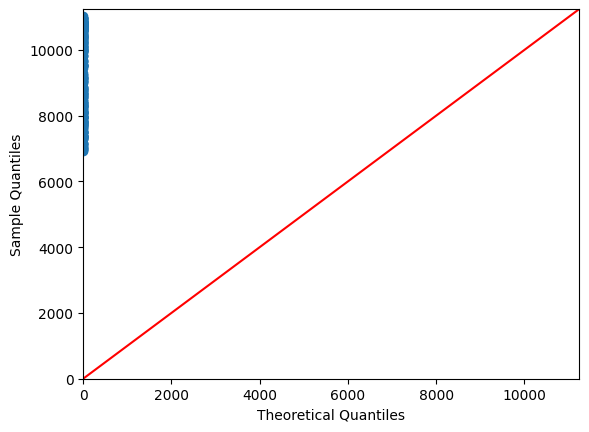

In [95]:
sm.qqplot(data.Ocupados, line ='45')
py.show()

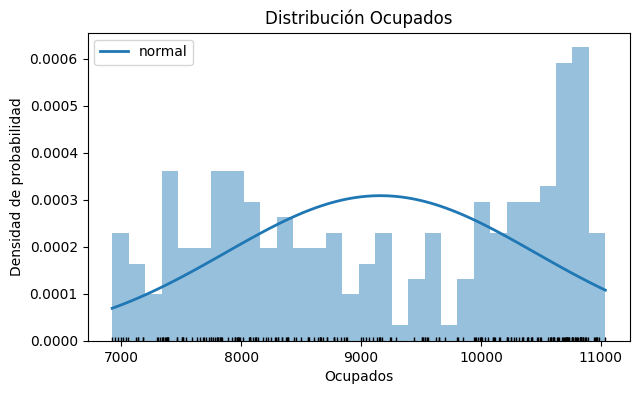

In [96]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(data.Ocupados)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data.Ocupados), max(data.Ocupados), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=data.Ocupados, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(data.Ocupados, np.full_like(data.Ocupados, 0.000), '|k', markeredgewidth=1)
ax.set_title('Distribución Ocupados')
ax.set_xlabel('Ocupados')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [97]:
stats.shapiro(data.Ocupados)

ShapiroResult(statistic=np.float64(0.9111439682568433), pvalue=np.float64(3.039085379954234e-10))

In [98]:
stats.jarque_bera(data.Ocupados)

SignificanceResult(statistic=np.float64(20.11813814008792), pvalue=np.float64(4.2795865091983345e-05))

### **6. Tendencia Lineal**

In [99]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     4729.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          1.02e-150
Time:                        04:18:16   Log-Likelihood:                -1559.9
No. Observations:                 222   AIC:                             3124.
Df Residuals:                     220   BIC:                             3131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6962.4958     36.871    188.835      0.0

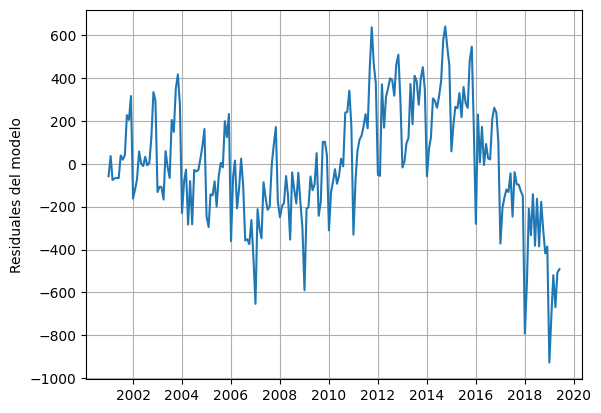

In [100]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

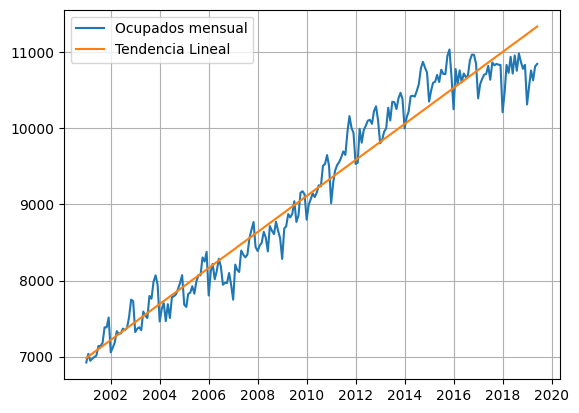

In [101]:
plt.plot(y,label="Ocupados mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [131]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [103]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11359.208189  10814.820716  11903.595662
1    11378.924388  10834.471236  11923.377539
2    11398.640587  10854.121178  11943.159995
3    11418.356786  10873.770542  11962.943029
4    11438.072984  10893.419328  11982.726641
5    11457.789183  10913.067536  12002.510831


=== Métricas pseudo-OOS sobre los últimos h meses ===
RMSE : 725.53
MAE  : 709.30
MAPE : 6.68%
Cobertura IC95%: 0.00%
Ancho promedio IC95: 1,004.86



,Real,Predicho,lower_95,upper_95,Error,AbsError,SqError,PctError_%,Dentro_IC95
mes,,,,,,,,,
2019-01-01,10314.438,11313.116,10810.849,11815.384,-998.678,998.678,997358.430,-9.682,False
2019-02-01,10557.917,11333.335,10831.004,11835.667,-775.418,775.418,601273.449,-7.344,False
2019-03-01,10760.776,11353.554,10851.158,11855.950,-592.778,592.778,351385.925,-5.509,False
2019-04-01,10632.028,11373.773,10871.312,11876.234,-741.745,741.745,550185.707,-6.977,False
2019-05-01,10813.000,11393.992,10891.465,11896.519,-580.992,580.992,337551.637,-5.373,False
2019-06-01,10848.000,11414.211,10911.618,11916.804,-566.211,566.211,320594.718,-5.219,False


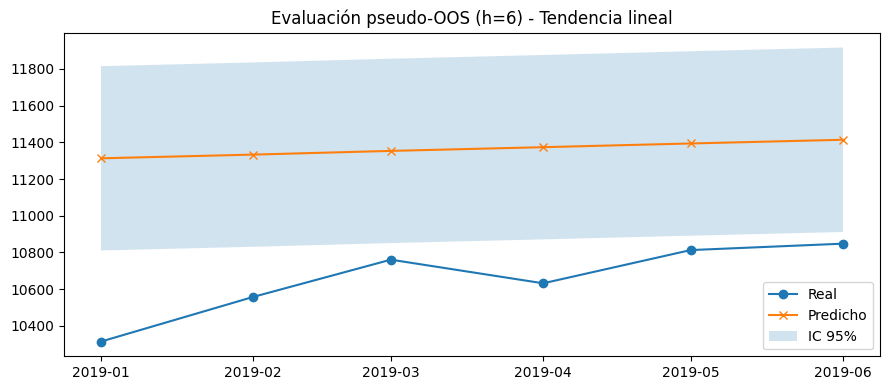

In [133]:
# ==== EVALUACIÓN PSEUDO-FUERA-DE-MUESTRA (tendencia lineal) ====
# Corta los últimos h meses, reentrena con el resto y evalúa esos h.

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Parámetros
h = 6  # horizonte a evaluar

# Serie original (como en tu notebook)
y_full = data["Ocupados"].copy()
idx_full = y_full.index

# Split: entrenamiento (todo menos los últimos h) y "test" (últimos h)
y_train = y_full.iloc[:-h]
y_test  = y_full.iloc[-h:]
idx_test = y_test.index

# === Modelo de tendencia lineal re-ajustado solo con entrenamiento ===
t_train = np.arange(1, len(y_train) + 1, dtype=float)
X_train = sm.add_constant(t_train)
lin_t_re = sm.OLS(y_train, X_train).fit()

# Matriz para pronosticar los últimos h meses (que ahora serán "futuros" respecto al train)
t_for = np.arange(len(y_train) + 1, len(y_train) + h + 1, dtype=float)
X_for  = sm.add_constant(t_for)

# Predicciones puntuales e IC 95%
dt = lin_t_re.get_prediction(X_for).summary_frame(alpha=0.05)
preds = dt[['mean', 'obs_ci_lower', 'obs_ci_upper']].rename(
    columns={'mean': 'Predicho', 'obs_ci_lower': 'lower_95', 'obs_ci_upper': 'upper_95'}
)
preds.index = idx_test  # fechas reales de los últimos h meses

# Comparación Real vs Predicho
comparacion = pd.concat(
    [y_test.rename("Real"), preds[['Predicho','lower_95','upper_95']]], axis=1
)
comparacion["Error"] = comparacion["Real"] - comparacion["Predicho"]
comparacion["AbsError"] = comparacion["Error"].abs()
comparacion["SqError"]  = comparacion["Error"]**2
comparacion["PctError_%"] = (comparacion["Error"] / comparacion["Real"]) * 100
comparacion["Dentro_IC95"] = (
    (comparacion["Real"] >= comparacion["lower_95"]) &
    (comparacion["Real"] <= comparacion["upper_95"])
)

# Métricas
RMSE = float(np.sqrt(comparacion["SqError"].mean()))
MAE  = float(comparacion["AbsError"].mean())
MAPE = float((comparacion["AbsError"]/comparacion["Real"]).mean()*100)
coverage_95 = float(comparacion["Dentro_IC95"].mean()*100)
avg_ic_width = float((comparacion["upper_95"] - comparacion["lower_95"]).mean())

print("=== Métricas pseudo-OOS sobre los últimos h meses ===")
print(f"RMSE : {RMSE:,.2f}")
print(f"MAE  : {MAE:,.2f}")
print(f"MAPE : {MAPE:.2f}%")
print(f"Cobertura IC95%: {coverage_95:.2f}%")
print(f"Ancho promedio IC95: {avg_ic_width:,.2f}\n")

# Tabla
display(comparacion.round(3))

# (Opcional) Gráfica
plt.figure(figsize=(9,4))
plt.plot(comparacion.index, comparacion["Real"], marker="o", label="Real")
plt.plot(comparacion.index, comparacion["Predicho"], marker="x", label="Predicho")
plt.fill_between(comparacion.index, comparacion["lower_95"], comparacion["upper_95"], alpha=0.2, label="IC 95%")
plt.title(f"Evaluación pseudo-OOS (h={h}) - Tendencia lineal")
plt.legend()
plt.tight_layout()
plt.show()

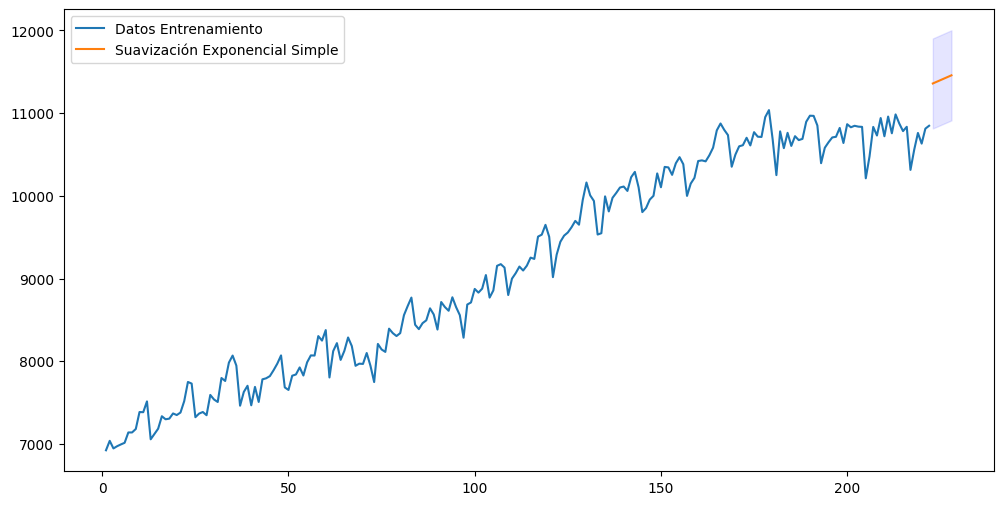

In [104]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **7. Tendencia Cuadratica**

In [105]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2
X = sm.add_constant(data[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2560.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          1.33e-152
Time:                        04:18:17   Log-Likelihood:                -1551.0
No. Observations:                 222   AIC:                             3108.
Df Residuals:                     219   BIC:                             3118.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6790.8804     53.552    126.810      0.0

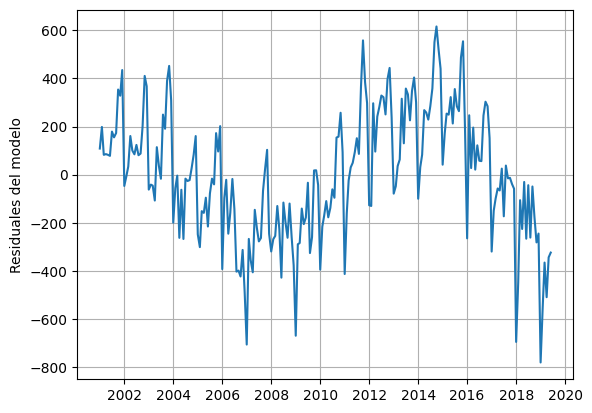

In [106]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

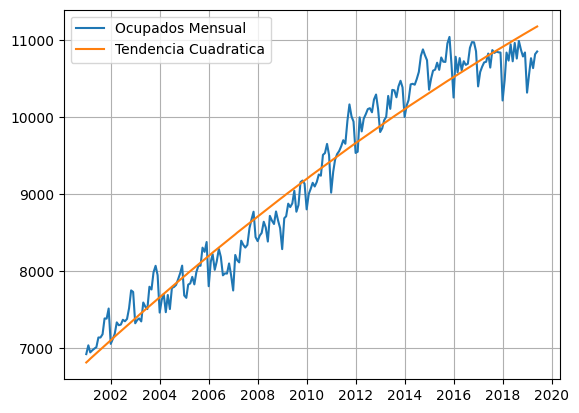

In [107]:
plt.plot(y,label="Ocupados Mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [108]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [109]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11187.592748  10657.511767  11717.673730
1    11202.691491  10672.226911  11733.156072
2    11217.749007  10686.889054  11748.608961
3    11232.765296  10701.497992  11764.032599
4    11247.740357  10716.053522  11779.427192
5    11262.674191  10730.555438  11794.792944


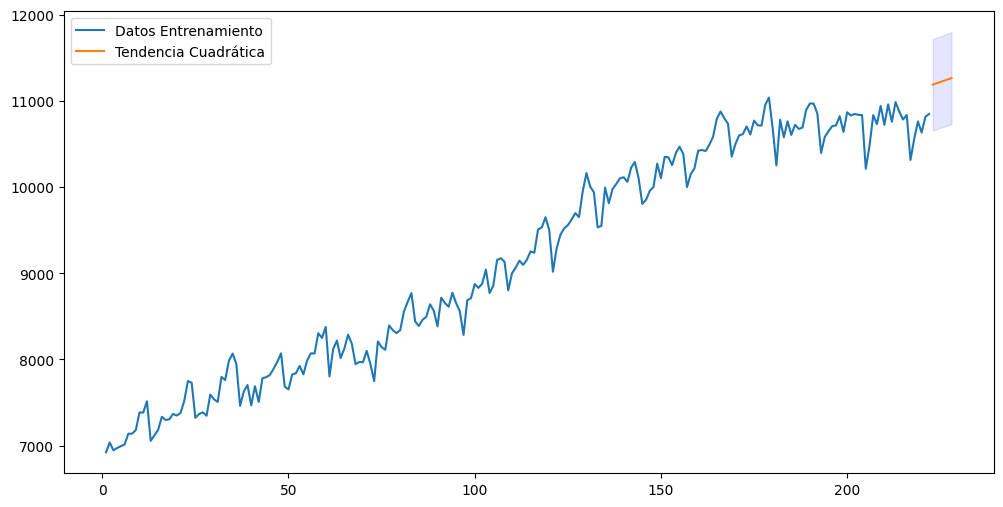

In [110]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia Cuadrática")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **8. Estimación de la Estacionalidad**

In [111]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2687
Date:                Fri, 07 Nov 2025   Prob (F-statistic):              0.991
Time:                        04:18:17   Log-Likelihood:                -1903.9
No. Observations:                 222   AIC:                             3832.
Df Residuals:                     210   BIC:                             3873.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    302.768     29.092      0.0

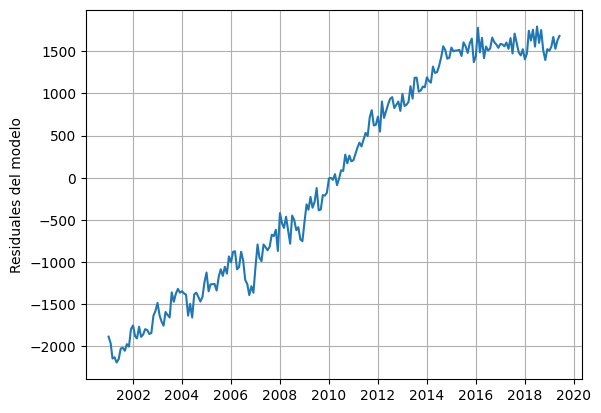

In [112]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

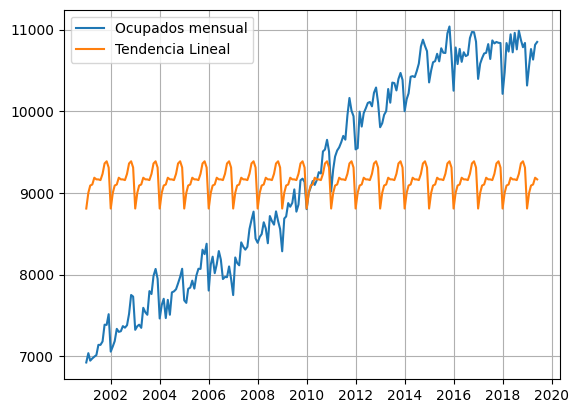

In [113]:
plt.plot(y,label="Ocupados mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [114]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=6, freq='MS')

# Create month dummies for the future dates, ensuring all months are represented
x_for = pd.get_dummies(range_dates.month, dtype=float)
# Add a constant term
x_for = sm.add_constant(x_for, has_constant='add')

# Reindex the future month dummies to match the columns of the original training data
# This ensures that all month columns are present, even if a month is not in the future range
# and that the constant is in the correct position.
X_for = x_for.reindex(columns=X.columns, fill_value=0)

In [115]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2019-07-01     9164.935167  6492.018221  11837.852112
2019-08-01     9156.633500  6483.716554  11829.550446
2019-09-01     9232.988500  6560.071554  11905.905446
2019-10-01     9359.934944  6687.017999  12032.851890
2019-11-01     9386.702222  6713.785277  12059.619168
2019-12-01     9310.332667  6637.415721  11983.249612


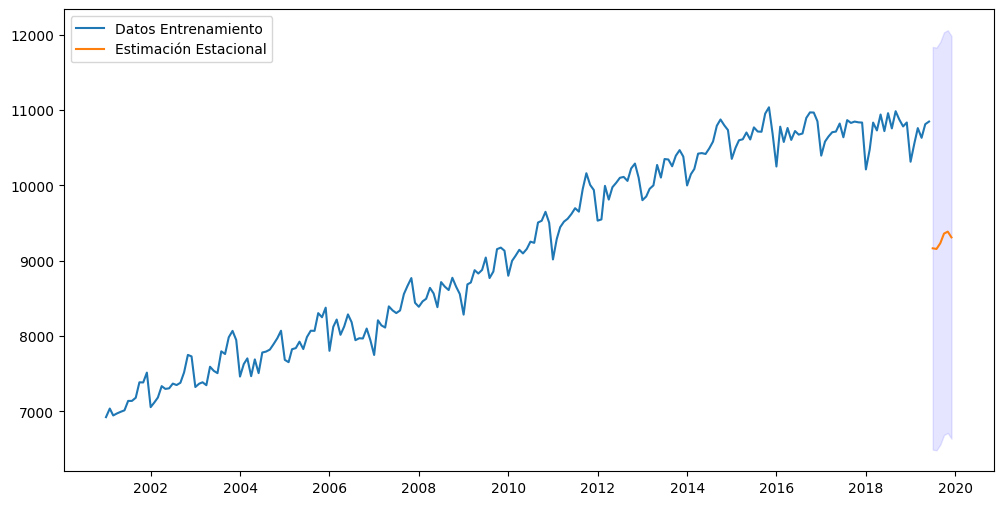

In [117]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **9. Tendencia + Estacionalidad**

In [118]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     502.6
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          3.33e-149
Time:                        04:18:18   Log-Likelihood:                -1519.4
No. Observations:                 222   AIC:                             3067.
Df Residuals:                     208   BIC:                             3114.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6508.3401     69.460     93.700      0.0

In [119]:
X

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,
2001-01-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,1.0,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,1.0,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-01,1.0,218.0,47524.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-01,1.0,219.0,47961.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-01,1.0,220.0,48400.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


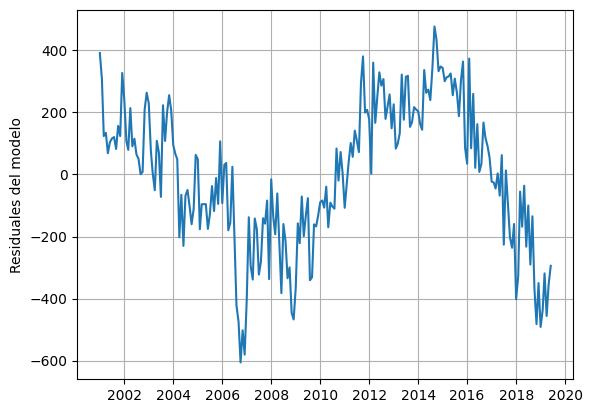

In [120]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

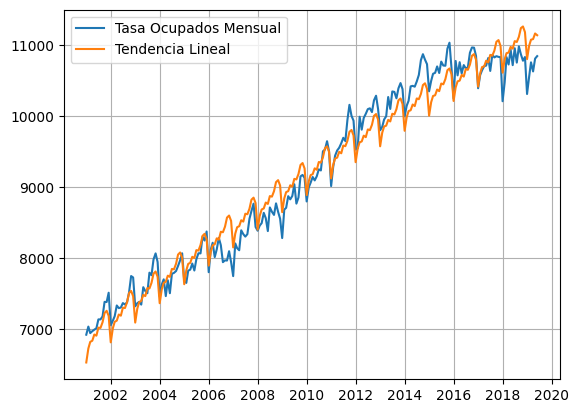

In [121]:
plt.plot(y,label="Tasa Ocupados Mensual")
plt.plot(season_pol_2.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [124]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )

range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True, dtype=float)

X_for= pd.concat([x_for_all,x_for_dummies],axis=1)
X_for = sm.add_constant(X_for, has_constant='add')

# Reindex X_for to match the columns of the original training data X
X_for = X_for.reindex(columns=X.columns, fill_value=0)

In [125]:
dt = season_pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2019-07-01    10899.308298  10416.761632  11381.854965
2019-08-01    11234.988869  10750.954256  11719.023481
2019-09-01    11307.022964  10822.688332  11791.357595
2019-10-01    11429.648504  10945.006353  11914.290654
2019-11-01    11452.094877  10967.137722  11937.052032
2019-12-01    11371.404416  10886.124786  11856.684047
